In [2]:
# Imports
import pickle
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../')

from src import customFunc as cf
from src import ansatzs as anz

In [3]:
with open("data/hamiltonian1.000.pkl", "rb") as f:
    hamiltonian = pickle.load(f)
with open("data/nuclear_repulsion1.000.pkl", "rb") as f:
    nuclear_repulsion = pickle.load(f)

In [4]:
# Create ansatz
num_layers=10
ansatz, n_params = anz.build_deep_ansatz(14, 1)
ansatz.decompose().draw("mpl")

c:\Anaconda\envs\qiskitTFM\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


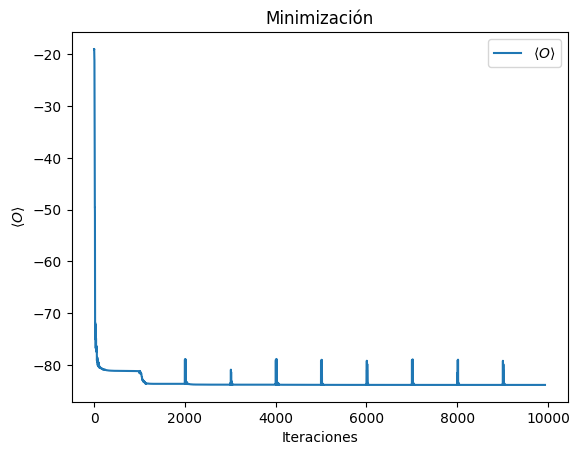

End of optimization. Found optimal value: -83.84768869427897


-74.90537303647787

In [20]:
ansatz, n_params = anz.build_deep_ansatz(14, 1)
VQE_minimization_mitigate_BP(ansatz, hamiltonian, num_layers, print_info=False, plot_info=True)["minimum_values"][0] + nuclear_repulsion

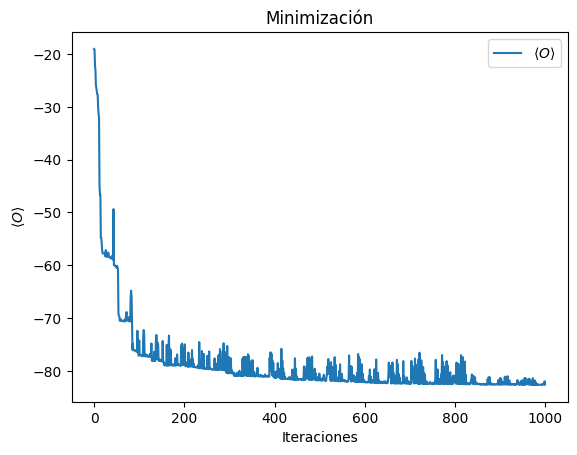

End of optimization. Found optimal value: -82.64893564866925


-73.70661999086815

In [19]:
ansatz, n_params = anz.build_deep_ansatz(14, 1)
VQE_minimization(ansatz, hamiltonian, print_info=False, plot_info=True)["minimum_values"][0] + nuclear_repulsion

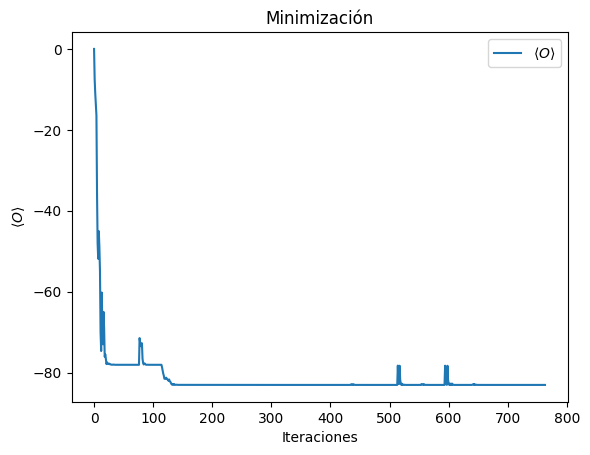

End of optimization. Found optimal value: -83.04670923761641


-74.10439357981531

In [17]:
ansatz, n_params = anz.build_Nlocal_ansatz(14, 1)
VQE_minimization_mitigate_BP(ansatz, hamiltonian, num_layers, print_info=False, plot_info=True)["minimum_values"][0] + nuclear_repulsion

In [15]:
import numpy as np
import matplotlib.pyplot as plt


from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import Estimator, BackendEstimator
from scipy.optimize import minimize
from scipy.stats import linregress
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit_aer import AerSimulator
def VQE_minimization_mitigate_BP(ansatz_circuit, observable, num_layers, initial_guess: str = "zero", minimizer: str = "COBYLA", print_info: bool = True, plot_info: bool = True):
    """
    Compute the VQE algorithm using different numbers of qubits, then plot the minimization progess and the derivatives information.
    -----------------------------------------
    Args:
        ansatz_function (method): A function defined as follows: ansatz_function(N_qubits (int)) -> qc (QuantumCircuit), num_params (int)
        base_observable (SparsePauliOp): The observable to be measured in its minimal form, it should use minQubits number of qubits.
        initial_guess (str or NumPy 1D array): "zero" initial guess with all parameters equal to cero, "rand" -> random initial guess. 1D Array -> the initial guess. default="zero".
        minimizer (str): scipy.optimize.minimize possible optimization methods, default="COBYLA".
    -----------------------------------------
    Returns:
        (Dictionary): 
            "minimum_values" : (list[float]): A list containing the minimum found for every number of qubits.
            "n_qubits" : (list[int]): A list containing the number of qubits used.
    """

    data = {"minimum_values": []}
    estimator = Estimator()
    num_params=ansatz.num_parameters

    # Initial parameters
    if initial_guess == "rand":
        initial_param_vector = np.random.random(num_params)
    elif initial_guess == "zero":
        initial_param_vector = np.zeros(num_params)
    elif initial_guess is np.ndarray():
        initial_param_vector = initial_guess
    else:
        print("Invalid initial guess, using all parameters as zero")

    # Current iteration information
    if print_info:
        print("\n=====================================================")
        print(f"Preparing execution for circuit:")
        display(ansatz_circuit.decompose().draw('mpl'))
        print(f"Optimization in progress.")
        print("\n=====================================================")
        
    def cost_func(param_layer, ansatz, observable, param_vector, start, end, estimator):
        full_param_vector = param_vector.copy()
        full_param_vector[start:end] = param_layer

        cost = cf.evaluate_observable(full_param_vector, ansatz, observable, estimator)
        cost_history_dict["iters"] += 1
        cost_history_dict["cost_history"].append(cost)
        return cost

    # Dictionary to save the evolution of the cost function
    cost_history_dict = {"iters": 0, "cost_history": []}

    # Optimization in layers
    param_vector=initial_param_vector
    params_per_layer = len(initial_param_vector) // num_layers
    for layer in range(num_layers):
        start = layer * params_per_layer
        end = start + params_per_layer
        initial_param_layer = param_vector[start:end]
        res = minimize(cost_func, initial_param_layer, args=(ansatz_circuit, observable, param_vector, start, end, estimator), method=minimizer)
        param_vector[start:end]=res.x

    # Save the results in the dictionary
    data["minimum_values"].append(res.fun)

    # Show the evolution of the cost function
    if plot_info:
        fig, ax = plt.subplots()
        ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label=r"$\langle O\rangle$")
        ax.set_xlabel("Iteraciones")
        ax.set_ylabel(r"$\langle O\rangle$")
        ax.set_title(f"Minimización")
        plt.legend()
        plt.show()
        print(f"End of optimization. Found optimal value: {res.fun}")
        print("=====================================================")
    return data

def VQE_minimization(ansatz_circuit, observable, initial_guess: str = "zero", minimizer: str = "COBYLA", print_info: bool = True, plot_info: bool = True):
    """
    Compute the VQE algorithm using different numbers of qubits, then plot the minimization progess and the derivatives information.
    -----------------------------------------
    Args:
        ansatz_function (method): A function defined as follows: ansatz_function(N_qubits (int)) -> qc (QuantumCircuit), num_params (int)
        base_observable (SparsePauliOp): The observable to be measured in its minimal form, it should use minQubits number of qubits.
        initial_guess (str or NumPy 1D array): "zero" initial guess with all parameters equal to cero, "rand" -> random initial guess. 1D Array -> the initial guess. default="zero".
        minimizer (str): scipy.optimize.minimize possible optimization methods, default="COBYLA".
    -----------------------------------------
    Returns:
        (Dictionary): 
            "minimum_values" : (list[float]): A list containing the minimum found for every number of qubits.
            "n_qubits" : (list[int]): A list containing the number of qubits used.
    """

    data = {"minimum_values": []}
    estimator = Estimator()
    num_params=ansatz.num_parameters

    # Initial parameters
    if initial_guess == "rand":
        initial_param_vector = np.random.random(num_params)
    elif initial_guess == "zero":
        initial_param_vector = np.zeros(num_params)
    elif initial_guess is np.ndarray():
        initial_param_vector = initial_guess
    else:
        print("Invalid initial guess, using all parameters as zero")

    # Current iteration information
    if print_info:
        print("\n=====================================================")
        print(f"Preparing execution for circuit:")
        display(ansatz_circuit.decompose().draw('mpl'))
        print(f"Optimization in progress.")
        print("\n=====================================================")
        
    def cost_func(param_vector, ansatz, observable, estimator):
        cost = cf.evaluate_observable(param_vector, ansatz, observable, estimator)
        cost_history_dict["iters"] += 1
        cost_history_dict["cost_history"].append(cost)
        return cost

    # Dictionary to save the evolution of the cost function
    cost_history_dict = {"iters": 0, "cost_history": []}

    # Optimization in layers
    res = minimize(cost_func, initial_param_vector, args=(ansatz_circuit, observable, estimator), method=minimizer)

    # Save the results in the dictionary
    data["minimum_values"].append(res.fun)

    # Show the evolution of the cost function
    if plot_info:
        fig, ax = plt.subplots()
        ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"], label=r"$\langle O\rangle$")
        ax.set_xlabel("Iteraciones")
        ax.set_ylabel(r"$\langle O\rangle$")
        ax.set_title(f"Minimización")
        plt.legend()
        plt.show()
        print(f"End of optimization. Found optimal value: {res.fun}")
        print("=====================================================")
    return data

In [ ]:
# Load the hamiltonians and repulsion energies to apply VQE
distances = np.linspace(0.25, 4, 16)
total_energies = []

for dist in distances:
    # Hamiltonians
    with open(f"data/hamiltonian{dist:.3f}.pkl", "rb") as f:
        hamiltonian = pickle.load(f)
    # Repulsion energies
    with open(f"data/nuclear_repulsion{dist:.3f}.pkl", "rb") as f:
        nuclear_repulsion = pickle.load(f)

    total_energies.append(cf.VQE_minimization_BP(anz.build_Nlocal_ansatz, 14, 14, hamiltonian, [], print_info=False, plot_info=False)["minimum_values"][0] + nuclear_repulsion)

plt.plot(distances, total_energies)

### Analizing BP for the equilibrium point, d = 1.000

In [6]:
with open("data/hamiltonian1.000.pkl", "rb") as f:
    hamiltonian = pickle.load(f)

print(hamiltonian)

data = []

for j in range(3):
    data.append(cf.variance_vs_nQubits(anz.build_Nlocal_ansatz, 14, 20, hamiltonian, j, 50, True, True, True))

SparsePauliOp(['IIIIIIIIIIIIII', 'IIIIIIIIIIIIIZ', 'IIIIIIIIIIIIZI', 'IIIIIIIIIIIIZZ', 'IIIIIIIIIIIYYI', 'IIIIIIIIIIIYYZ', 'IIIIIIIIIIIXXI', 'IIIIIIIIIIIXXZ', 'IIIIIIIIIIYZYI', 'IIIIIIIIIIYZYZ', 'IIIIIIIIIIXZXI', 'IIIIIIIIIIXZXZ', 'IIIIIIIIYZZZYI', 'IIIIIIIIYZZZYZ', 'IIIIIIIIXZZZXI', 'IIIIIIIIXZZZXZ', 'IIIIIIIYZZZZYI', 'IIIIIIIYZZZZYZ', 'IIIIIIIXZZZZXI', 'IIIIIIIXZZZZXZ', 'IIIIIIIIIIIZII', 'IIIIIIIIIIIZIZ', 'IIIIIIIIIIYYII', 'IIIIIIIIIIYYIZ', 'IIIIIIIIIIXXII', 'IIIIIIIIIIXXIZ', 'IIIIIIIIYZZYII', 'IIIIIIIIYZZYIZ', 'IIIIIIIIXZZXII', 'IIIIIIIIXZZXIZ', 'IIIIIIIYZZZYII', 'IIIIIIIYZZZYIZ', 'IIIIIIIXZZZXII', 'IIIIIIIXZZZXIZ', 'IIIIIIIIIIZIII', 'IIIIIIIIIIZIIZ', 'IIIIIIIIYZYIII', 'IIIIIIIIYZYIIZ', 'IIIIIIIIXZXIII', 'IIIIIIIIXZXIIZ', 'IIIIIIIYZZYIII', 'IIIIIIIYZZYIIZ', 'IIIIIIIXZZXIII', 'IIIIIIIXZZXIIZ', 'IIIIIIIIIZIIII', 'IIIIIIIIIZIIIZ', 'IIIIIIIIZIIIII', 'IIIIIIIIZIIIIZ', 'IIIIIIIYYIIIII', 'IIIIIIIYYIIIIZ', 'IIIIIIIXXIIIII', 'IIIIIIIXXIIIIZ', 'IIIIIIIZIIIIII', 'IIIIIIIZIIIIIZ', 'IIIIIIZIIIII

KeyboardInterrupt: 